In [25]:
from ase.io import read
import pandas as pd
from columns import columns
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from dscribe.descriptors import SOAP
import torch

mof = read("../CIF 2078717.cif")


/home/mmm9886/.conda/envs/soap_analysis/lib/python3.9/site-packages/ase/io/cif.py:408: UserWarning: crystal system 'monoclinic' is not interpreted for space group Spacegroup(14, setting=1). This may result in wrong setting!
  warnings.warn(


In [26]:
soap = SOAP(
        species=sorted(set(mof.get_chemical_symbols())),
        periodic=True,
        r_cut=5.0,
        n_max= 1,
        l_max= 1,
        sigma = 0.2,
        average = 'inner',
        sparse=False
    )

In [27]:
soap.get_number_of_features()

30

In [8]:
mof_soap = soap.create(mof)

In [9]:
mof_soap.shape

(128, 30)

In [26]:
mof_soap.shape[1]

30

In [11]:
from torch_geometric.nn.aggr import SetTransformerAggregation

In [12]:
encoder_decoder = SetTransformerAggregation(30)

In [13]:
soap_tensor = torch.FloatTensor(mof_soap)

In [14]:
group_indices = torch.zeros(soap_tensor.shape[0], dtype=torch.long)

In [15]:
group_indices.shape

torch.Size([128])

In [16]:
output = encoder_decoder.forward(soap_tensor, index = group_indices)

In [23]:
output[0]

tensor([ 0.0352, -0.2814, -0.2244,  0.0450,  0.2589, -0.0330,  0.1081, -0.0797,
         0.3186,  0.1085,  0.3081,  0.1227, -0.1212,  0.5334,  0.6499,  0.1543,
         0.4863,  0.3533,  0.3133,  0.1523,  0.0283,  0.1893,  0.1026, -0.1922,
        -0.1749, -0.2077,  0.1025,  0.1414,  0.5102,  0.2550],
       grad_fn=<SelectBackward0>)

In [19]:
avg_soap = soap.create(mof)

In [20]:
avg_soap

array([ 1.27791181e-02,  4.01042309e-35,  2.09243174e-02, -3.90503349e-35,
        8.46882039e-03, -7.53961724e-36,  2.09172821e-02,  7.11104630e-36,
        4.16536455e-03, -1.72884370e-40,  3.42611325e-02,  4.35344449e-35,
        1.38667070e-02,  7.44443227e-36,  3.42496130e-02, -1.26239816e-35,
        6.82029927e-03,  3.01011439e-40,  5.61235277e-03,  1.83270845e-36,
        1.38620446e-02, -1.91741120e-36,  2.76041930e-03,  6.82293349e-41,
        3.42380975e-02,  7.70037500e-36,  6.81800612e-03, -2.06019306e-40,
        1.35770416e-03,  6.61403140e-45])

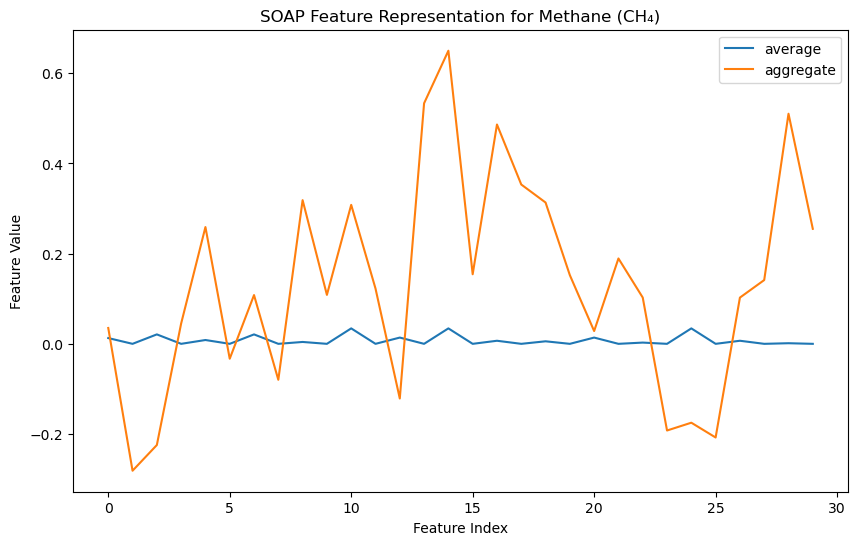

In [24]:
import matplotlib.pyplot as plt

# Plot SOAP features for Carbon and Hydrogen atoms
plt.figure(figsize=(10, 6))

# for i in range(soap_features.shape[0]):
#     plt.plot(soap_features[i], label=f'Atom {i} ({methane.get_chemical_symbols()[i]})')

plt.plot(avg_soap, label=f'average')
plt.plot(output[0].detach().numpy(), label=f'aggregate')

plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.title("SOAP Feature Representation for Methane (CH₄)")
plt.legend()
plt.show()

In [2]:
import torch
from torch_geometric.nn.aggr import SetTransformerAggregation

# Load the checkpoint
checkpoint = torch.load('optimized_models.pth', map_location='cpu')

# Initialize SetTransformer with your exact parameters
encoder_decoder = SetTransformerAggregation(
    channels=484,
    num_seed_points=1,
    num_encoder_blocks=1,
    num_decoder_blocks=1,
    heads=4,
    concat=True,
    layer_norm=True,
    dropout=0.3
)

# Load only the encoder_decoder weights
encoder_decoder.load_state_dict(checkpoint['encoder_decoder'])
encoder_decoder.eval()

print("Encoder-decoder loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in encoder_decoder.parameters()):,}")

Encoder-decoder loaded successfully!
Model parameters: 3,762,132


In [8]:
import torch.nn as nn

In [9]:
class MOFPropertyPredictor(nn.Module):
    """
    Simple neural network that takes SetTransformer output and predicts gas uptake.
    """
    
    def __init__(self, aggregated_dim: int, hidden_dim: int = 128):
        super().__init__()
        
        self.predictor = nn.Sequential(
            nn.Linear(aggregated_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            # nn.Linear(hidden_dim, hidden_dim // 2),
            # nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1)  # Single output for gas uptake
        )
    
    def forward(self, aggregated_features):
        return self.predictor(aggregated_features).squeeze()

In [11]:
property_predictor = MOFPropertyPredictor(484)

In [21]:
property_predictor.load_state_dict(checkpoint['property_predictor'])

<All keys matched successfully>

In [20]:
checkpoint['property_predictor']

OrderedDict([('predictor.0.weight',
              tensor([[-0.0145, -0.0022, -0.0089,  ..., -0.0229, -0.0092,  0.0117],
                      [ 0.0190, -0.0007, -0.0356,  ...,  0.0022, -0.0114,  0.0046],
                      [-0.0263, -0.0272,  0.0072,  ..., -0.0402, -0.0405, -0.0077],
                      ...,
                      [ 0.0462,  0.0264, -0.0065,  ..., -0.0223,  0.0414,  0.0339],
                      [-0.0463,  0.0312, -0.0061,  ...,  0.0515,  0.0343,  0.0167],
                      [ 0.0218,  0.0149, -0.0357,  ..., -0.0200,  0.0116, -0.0187]])),
             ('predictor.0.bias',
              tensor([-0.0532,  0.0398, -0.0241, -0.0455, -0.0208,  0.0047,  0.0343,  0.0517,
                      -0.0247,  0.0214, -0.0137,  0.0216,  0.0093,  0.0500,  0.0231,  0.0226,
                      -0.0050, -0.0169,  0.0250, -0.0078, -0.0270,  0.0591,  0.0145, -0.0107,
                      -0.0373, -0.0396, -0.0442, -0.0147,  0.0206,  0.0143,  0.0068,  0.0286,
                    

In [24]:
property_predictor.predictor[2]

Dropout(p=0.3, inplace=False)

In [5]:
checkpoint['property_predictor']

OrderedDict([('predictor.0.weight',
              tensor([[-0.0145, -0.0022, -0.0089,  ..., -0.0229, -0.0092,  0.0117],
                      [ 0.0190, -0.0007, -0.0356,  ...,  0.0022, -0.0114,  0.0046],
                      [-0.0263, -0.0272,  0.0072,  ..., -0.0402, -0.0405, -0.0077],
                      ...,
                      [ 0.0462,  0.0264, -0.0065,  ..., -0.0223,  0.0414,  0.0339],
                      [-0.0463,  0.0312, -0.0061,  ...,  0.0515,  0.0343,  0.0167],
                      [ 0.0218,  0.0149, -0.0357,  ..., -0.0200,  0.0116, -0.0187]])),
             ('predictor.0.bias',
              tensor([-0.0532,  0.0398, -0.0241, -0.0455, -0.0208,  0.0047,  0.0343,  0.0517,
                      -0.0247,  0.0214, -0.0137,  0.0216,  0.0093,  0.0500,  0.0231,  0.0226,
                      -0.0050, -0.0169,  0.0250, -0.0078, -0.0270,  0.0591,  0.0145, -0.0107,
                      -0.0373, -0.0396, -0.0442, -0.0147,  0.0206,  0.0143,  0.0068,  0.0286,
                    

In [8]:
encoder_decoder

SetTransformerAggregation(484, num_seed_points=2, heads=4, layer_norm=True, dropout=0.3)

In [17]:
from aggregate_soap_generating_script import aggregate
import torch
from torch_geometric.nn.aggr import SetTransformerAggregation
import tqdm
import os
from ase.io import read
import pandas as pd
from columns import slice_column, columns
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from dscribe.descriptors import SOAP
import os
from tqdm import tqdm
from multiprocessing import Pool
from soap import *

In [26]:
aggregated_column_names = []
# First 484 columns (seed0)
for col in all_soap_columns:
    aggregated_column_names.append(f"{col}_seed0")
# Next 484 columns (seed1) 
for col in all_soap_columns:
    aggregated_column_names.append(f"{col}_seed1")

In [27]:
len(aggregated_column_names)

968

In [28]:
aggregated_column_names

['Ag-Ag_1_seed0',
 'Ag-Ag_2_seed0',
 'Ag-C_1_seed0',
 'Ag-C_2_seed0',
 'Ag-Cr_1_seed0',
 'Ag-Cr_2_seed0',
 'Ag-O_1_seed0',
 'Ag-O_2_seed0',
 'Al-Al_1_seed0',
 'Al-Al_2_seed0',
 'Al-C_1_seed0',
 'Al-C_2_seed0',
 'Al-F_1_seed0',
 'Al-F_2_seed0',
 'Al-H_1_seed0',
 'Al-H_2_seed0',
 'Al-N_1_seed0',
 'Al-N_2_seed0',
 'Al-O_1_seed0',
 'Al-O_2_seed0',
 'Al-P_1_seed0',
 'Al-P_2_seed0',
 'Al-S_1_seed0',
 'Al-S_2_seed0',
 'Br-Br_1_seed0',
 'Br-Br_2_seed0',
 'Br-C_1_seed0',
 'Br-C_2_seed0',
 'Br-Cd_1_seed0',
 'Br-Cd_2_seed0',
 'Br-Ce_1_seed0',
 'Br-Ce_2_seed0',
 'Br-Cl_1_seed0',
 'Br-Cl_2_seed0',
 'Br-Co_1_seed0',
 'Br-Co_2_seed0',
 'Br-Cu_1_seed0',
 'Br-Cu_2_seed0',
 'Br-F_1_seed0',
 'Br-F_2_seed0',
 'Br-Fe_1_seed0',
 'Br-Fe_2_seed0',
 'Br-H_1_seed0',
 'Br-H_2_seed0',
 'Br-La_1_seed0',
 'Br-La_2_seed0',
 'Br-Li_1_seed0',
 'Br-Li_2_seed0',
 'Br-N_1_seed0',
 'Br-N_2_seed0',
 'Br-O_1_seed0',
 'Br-O_2_seed0',
 'Br-Pd_1_seed0',
 'Br-Pd_2_seed0',
 'Br-S_1_seed0',
 'Br-S_2_seed0',
 'Br-Si_1_seed0',
 'Br

In [29]:
folder_path = '../CIF_files'
filenames = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Determine all 484 columns first (do this once before the loop)
print("Determining all unique SOAP columns...")
all_soap_columns = set()
for filename in tqdm(filenames, desc="Sampling for columns"):  # Sample to get all columns
    try:
        _, structure, species = read_cif(filename)
        soap_out, soap = S(structure, species)
        columns = slice_column(soap, list(species))
        all_soap_columns.update(columns)
    except:
        continue

all_soap_columns = sorted(list(all_soap_columns))
print(f"Found {len(all_soap_columns)} unique SOAP columns")

# Now process all files with fixed columns
soap_df = pd.DataFrame(columns=all_soap_columns + ['filename'])

with Pool() as pool:
    for filename, structure, species in tqdm(pool.imap_unordered(read_cif, filenames), total=len(filenames), desc="Reading CIFs"):
        try:
            soap_out, soap = S(structure, species)
            
            # Get current columns for this MOF
            current_columns = slice_column(soap, list(species))
            
            # Create padded SOAP features (484 dimensions)
            padded_soap = np.zeros((soap_out.shape[0], len(all_soap_columns)))
            
            # Fill in actual values where columns exist
            for i, col in enumerate(current_columns):
                if col in all_soap_columns:
                    col_idx = all_soap_columns.index(col)
                    padded_soap[:, col_idx] = soap_out[:, i]
            
            # Now pass padded SOAP to encoder_decoder
            aggr_out = set_transform_aggregation(padded_soap, encoder_decoder)
            
            # Create DataFrame with all columns (no more reindexing!)
            df = pd.DataFrame([aggr_out], columns=aggregated_column_names)
            df['filename'] = filename
            
            soap_df = pd.concat([soap_df, df], ignore_index=True)
            
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue

return soap_df

Determining all unique SOAP columns...


Sampling for columns:   0%|          | 0/3089 [00:00<?, ?it/s]/home/mmm9886/.conda/envs/soap_analysis/lib/python3.9/site-packages/ase/io/cif.py:408: UserWarning: crystal system 'triclinic' is not interpreted for space group Spacegroup(1, setting=1). This may result in wrong setting!
  warnings.warn(
Sampling for columns: 100%|██████████| 3089/3089 [01:54<00:00, 26.94it/s]

Found 484 unique SOAP columns



Reading CIFs:   0%|          | 0/3089 [00:00<?, ?it/s]/home/mmm9886/.conda/envs/soap_analysis/lib/python3.9/site-packages/ase/io/cif.py:408: UserWarning: crystal system 'triclinic' is not interpreted for space group Spacegroup(1, setting=1). This may result in wrong setting!
  warnings.warn(
/home/mmm9886/.conda/envs/soap_analysis/lib/python3.9/site-packages/ase/io/cif.py:408: UserWarning: crystal system 'triclinic' is not interpreted for space group Spacegroup(1, setting=1). This may result in wrong setting!
  warnings.warn(
/home/mmm9886/.conda/envs/soap_analysis/lib/python3.9/site-packages/ase/io/cif.py:408: UserWarning: crystal system 'triclinic' is not interpreted for space group Spacegroup(1, setting=1). This may result in wrong setting!
  warnings.warn(
/home/mmm9886/.conda/envs/soap_analysis/lib/python3.9/site-packages/ase/io/cif.py:408: UserWarning: crystal system 'triclinic' is not interpreted for space group Spacegroup(1, setting=1). This may result in wrong setting!
  warn

SyntaxError: 'return' outside function (4056627664.py, line 52)